In [1]:
import pandas as pd
import datetime
import os

In [2]:
current_dir = os.getcwd()
targer_dir = os.path.abspath(os.path.join(current_dir, ".."))
file_path = os.path.join(targer_dir,"data_saham.csv")

In [3]:
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])

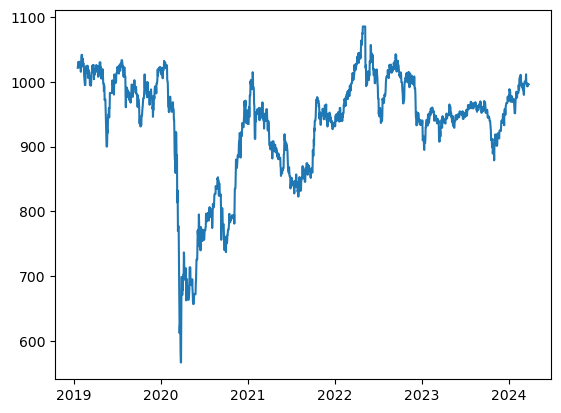

In [4]:
import matplotlib.pyplot as plt

plt.plot(data['Date'], data['Target'])

In [5]:
dates = data.pop('Date')

In [6]:
X = data.drop(columns ='Target')
y = data['Target']

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
split = int(0.8* len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
date_test = dates[split:]

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
from sklearn.svm import SVR

In [9]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

param_grid = {
    'C': [ 1,5, 10,20, 30,40,50,60,70,80,90,100,110,120,130,140,150],
    'gamma': [1, 0.1, 0.01, 0.005, 0.001,0.0005],
}

svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='max_error')
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_

print("Best SVR Model:")
print("Best Parameters:", grid_search.best_params_)


Best SVR Model:
Best Parameters: {'C': 120, 'gamma': 0.005}


In [10]:
best_params = grid_search.best_params_
C_best = best_params['C']
gamma_best = best_params['gamma']

model = SVR(kernel='rbf', C=C_best, gamma=gamma_best)
model.fit(X_train, y_train)

SVR(C=120, gamma=0.005)

In [11]:
kf = KFold(n_splits=20, shuffle=True, random_state=42)
cross_val_result = cross_val_score(model, X_train, y_train, cv = kf)
print(cross_val_result)

[0.98877493 0.98306497 0.98420852 0.97742282 0.97687318 0.98370734
 0.97958253 0.9823412  0.98746415 0.98074441 0.98021166 0.98222174
 0.98755374 0.98472054 0.98826916 0.98226919 0.9847366  0.98579378
 0.96720861 0.98651062]


In [12]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
r2score = r2_score(y_test,y_pred)
print("mae = ", mae)
print("mse = ", mse)
print("r2_score = ", r2score)

mae =  5.375921874777524
mse =  46.38180754851913
r2_score =  0.9242334138418129


In [13]:
import matplotlib.pyplot as plt

temp = []
forecast_SVR = []
prediction_harga = []
date_forecast = pd.DataFrame(columns=["Date"])
n = data.shape[1]-1
X_forecast = pd.DataFrame()
for target in range(data.shape[1]-1,0,-1):
    X_forecast[f'Target-{target}'] = None
price_pred = pd.DataFrame(columns=["Price"])
date_forecast.loc[0] = dates.iloc[-1]
temp.append(data.iloc[-1].values)
for t in range(0,n):
    forecast_SVR.append(temp[0][t])
    
for i in range(1, 30):
    X_forecast.loc[i - 1] = forecast_SVR[-n:]
    X_forecast_scaled = sc.transform(X_forecast.iloc[[i - 1]])
    svr_pred = model.predict(X_forecast_scaled)  

    forecast_SVR.append(svr_pred[0]) 

    price_pred.loc[i - 1] = svr_pred[0]  
    
    next_date = date_forecast.iloc[0]["Date"] + datetime.timedelta(days=i)
    date_forecast.loc[i] = {"Date": next_date}

date_forecast = date_forecast[:len(date_forecast) - 1]

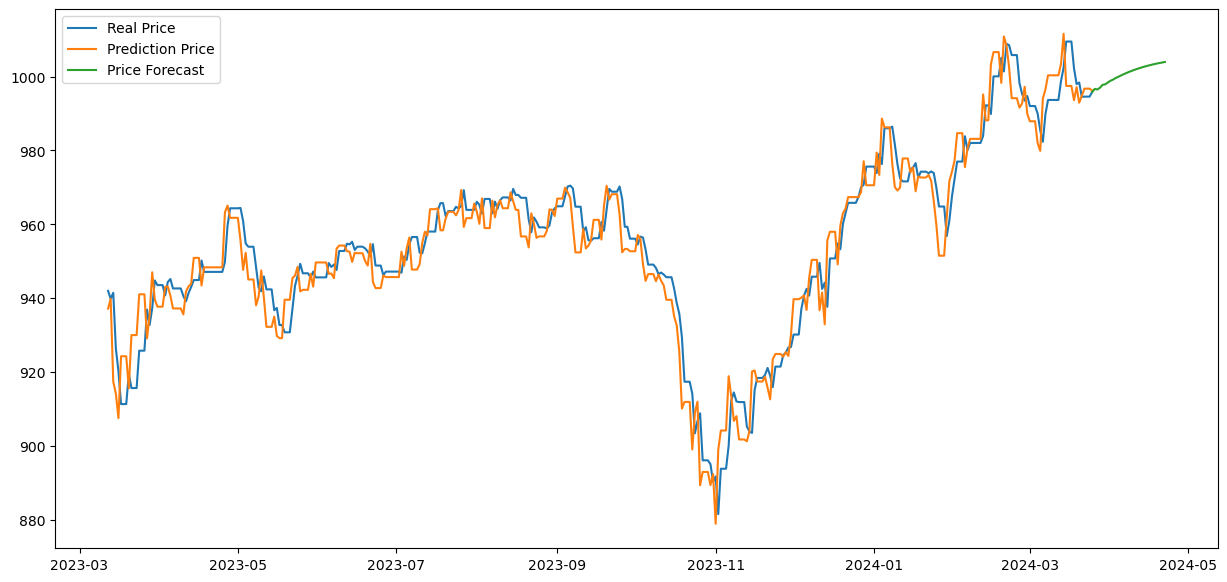

In [14]:
plt.figure(figsize=[15,7])
plt.plot(date_test, y_pred)
plt.plot(date_test, y_test)
plt.plot(date_forecast,price_pred)
plt.legend(["Real Price","Prediction Price","Price Forecast"])